In [1]:
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import collections
import glob

import fire
import numpy as np
import pandas as pd
import torch
from configs import ROOT_DIR
from matplotlib import pyplot as plt

metrics = {"msbpe":{},"ve":{}, "all_reward_sums": {}, "hyper_params": {}}

# results = pd.DataFrame(columns = ['agent', 'score', 'params'],
#                                   index = list(range(MAX_EVALS)))

agent_names_in_plot={"NN": "Uniform", "NNP": "Uncertainty", "NNT":"Diversity"}
env_names_in_plot={'DoorWorldWide3':'GridWorldD3','DoorWorldWide11':'DoorWorldWide13X13D4'}
titles = {"msbpe":'MSPBE',"ve":'Value Error (VE)', "all_reward_sums":'Sum of Rewards'}
filtered_agent_list = ["Uniform", "PER", "GEO", "CER", "Sarsa"]
y_lims = {"msbpe","ve", "all_reward_sums"}
y_labels = {"msbpe":"MSPBE","ve":"Value Error (VE)", "all_reward_sums":"Sum of Rewards"}
stats_metric = {"msbpe":"AUC","ve":"AUC", "all_reward_sums":"Average Rewards"}

env_infos = {
    'MDP': {
        "maze_dim": [1, 102], 
        "start_state": [0, 51], 
        "end_state": [0, 101],
        "obstacles":[],
        "doors": {tuple():[]},
    },
}

num_episodes = 300
from mdp.run_single_job import num_runs
from mdp.write_jobs import agents, params_to_search

In [3]:
num_episodes = 300
from mdp.run_single_job import num_runs


def dict_merge(dct, merge_dct):
    """ Recursive dict merge. Inspired by :meth:``dict.update()``, instead of
    updating only top-level keys, dict_merge recurses down into dicts nested
    to an arbitrary depth, updating keys. The ``merge_dct`` is merged into
    ``dct``.
    :param dct: dict onto which the merge is executed
    :param merge_dct: dct merged into dct
    :return: None
    """
    for k, v in merge_dct.items():
        if (k in dct and isinstance(dct[k], dict)
                and isinstance(merge_dct[k], collections.Mapping)):
            dict_merge(dct[k], merge_dct[k])
        elif k in dct and isinstance(dct[k], list) and isinstance(v, list):
            print('hehehe')
        else:
            dct[k] = merge_dct[k]

In [4]:
for file in glob.glob(str(ROOT_DIR/'metrics/*')):
    dict_merge(metrics, torch.load(file))

/home/derek/anaconda3/envs/fpp/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  app.launch_new_instance()


In [5]:
metrics['all_reward_sums']['MDP'].keys()

dict_keys(['Uniform_step_size_0.01', 'Uniform_step_size_0.00125'])

{'Uniform': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625]},
 'Sarsa': {'step_size': [0.5,
   0.25,
   0.125,
   0.0625,
   0.03125,
   0.015625,
   0.0078125]},
 'CER': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625]},
 'PER': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625],
  'buffer_alpha': [0, 0.4, 0.6, 0.7, 0.8],
  'buffer_beta': [0, 0.4, 0.5, 0.6, 1]},
 'GEO': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625],
  'buffer_alpha': [0, 0.4, 0.6, 0.7, 0.8],
  'buffer_beta': [0, 0.4, 0.5, 0.6, 1],
  'p': [0.1, 0.3, 0.5, 0.7, 0.9]}}

In [16]:
env = 'MDP'
param = 'step_size'
metric_name = 'all_reward_sums'

In [19]:
def get_metric_stats(env, metric_name, algorithm):
    if metric_name == "all_reward_sums":
        algorithm_stats = -np.around(np.mean(metrics[metric_name][env][algorithm]),decimals=4)
    else:
        algorithm_stats = np.around(np.mean(metrics[metric_name][env][algorithm])*300,decimals=4)
    return algorithm_stats

In [23]:
get_metric_stats(env, metric_name, 'Uniform_step_size_0.01')

-20.7533

Uniform step_size 0.01
['Uniform_step_size_0.01']
Uniform step_size 0.005
[]
Uniform step_size 0.0025
[]
Uniform step_size 0.00125
['Uniform_step_size_0.00125']
Uniform step_size 0.000625
[]
PER step_size 0.01
[]
PER step_size 0.005
[]
PER step_size 0.0025
[]
PER step_size 0.00125
[]
PER step_size 0.000625
[]
GEO step_size 0.01
[]
GEO step_size 0.005
[]
GEO step_size 0.0025
[]
GEO step_size 0.00125
[]
GEO step_size 0.000625
[]
CER step_size 0.01
[]
CER step_size 0.005
[]
CER step_size 0.0025
[]
CER step_size 0.00125
[]
CER step_size 0.000625
[]
Sarsa step_size 0.5
[]
Sarsa step_size 0.25
[]
Sarsa step_size 0.125
[]
Sarsa step_size 0.0625
[]
Sarsa step_size 0.03125
[]
Sarsa step_size 0.015625
[]
Sarsa step_size 0.0078125
[]


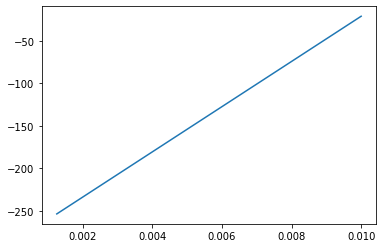

In [32]:
for agent_type in filtered_agent_list:
    x_values = []
    y_values = []
    for val in params_to_search[agent_type][param]:
        print(agent_type, param, val)
        agent_names = list(filter(lambda x: x.startswith(agent_type) and f'{param}_{val}' in x,  list(metrics[metric_name][env].keys())))
        print(agent_names)
        lst_of_stats = [get_metric_stats(env, metric_name, agent_name) for agent_name in agent_names]
        if lst_of_stats:
            x_values.append(val)
            y_values.append(max(lst_of_stats))
            
    plt.plot(x_values,y_values)
            

In [44]:
params_to_search

{'Uniform': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625]},
 'Sarsa': {'step_size': [0.5,
   0.25,
   0.125,
   0.0625,
   0.03125,
   0.015625,
   0.0078125]},
 'CER': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625]},
 'PER': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625],
  'buffer_alpha': [0, 0.4, 0.6, 0.7, 0.8],
  'buffer_beta': [0, 0.4, 0.5, 0.6, 1]},
 'GEO': {'step_size': [0.01, 0.005, 0.0025, 0.00125, 0.000625],
  'buffer_alpha': [0, 0.4, 0.6, 0.7, 0.8],
  'buffer_beta': [0, 0.4, 0.5, 0.6, 1],
  'p': [0.1, 0.3, 0.5, 0.7, 0.9]}}

In [45]:
['agent'].remove('agent')